***CLUSTERING***
- resource: https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
- main idea: clustering suffers from the limitations of the algorithms and the curse of dimensionality
- All clustering methods can roughly be divided into four groups:  

1) **Hierarchical clustering** (agglomerative)
    - sensitive to noise in the data
2) **Centroid-based clustering** (K-means, Gaussian Mixture Models)
    - can only handle clusters with spherical or ellipsoid symmetry
3) **Graph-based clustering** (Spectral, SNN-cliq, Seurat)
    - perhaps most robust for high-dimensional data as it uses distance on a graph which is more meaningful in high dimensions as opposed to the Euclidean distance
4) **Density-based clustering** (Mean-Shift, DBSCAN, OPTICS, HDBSCAN) 
    - allows clustering without specifying the number of clusters. 
    - algorithms are also cluster shape independent and capture any topology of scRNAseq data


In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import pandas as pd


78.85144142614601


Text(0.5, 1.0, 'KMeans Elbow Plot')

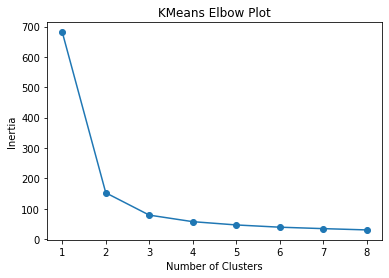

In [4]:
iris = datasets.load_iris()

# Create a dataframe to contain 4 feature values of the flowers and the label
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
labels = pd.DataFrame({'label':iris.target})
iris_df = iris_df.join(labels)


# Implement KMeans clustering using the four feature values
X=iris_df.iloc[:,:4]
kmeans = KMeans(n_clusters = 3)
target_pred = kmeans.fit_predict(X)
print(kmeans.inertia_)

# Figuring out the best number of clusters to use
idx = 0
inertia = []

for n_cluster in range(1,9):
    kmeans = KMeans(n_clusters = n_cluster)
    target_pred = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    idx += 1

# Plot the number of clusters vs. inertia values. ELBOW PLOT to find optimal number of clusters
plt.plot(range(1,9), inertia,linestyle='-', marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Plot')


This technique for choosing the best value for the number of clusters is rather coarse. A more precise apporach (but also more computationally expensive) is to use the silhouette score, which is the mean silhouette coefficient over all the distances.  

silhouette coefficient = (b-a)/max(a,b), where
- a is the mean distance to the other instances in the same cluster
- b is the mean nearest-cluster distance
- coefficient can vary between -1 and +1 
- coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters
- coefficient close to 0 means that it is close to a cluster boundary
- coefficient close to -1 means that the instance may have been assigned to the wrong cluster

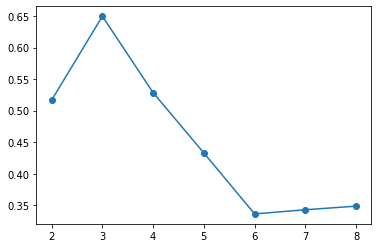

In [10]:
from sklearn.metrics import silhouette_score
# Figuring out the best number of clusters to use
idx = 0
s_score = []

for n_cluster in range(2,9):
    kmeans = KMeans(n_clusters = n_cluster)
    target_pred = kmeans.fit_predict(X)
    s_score.append(silhouette_score(X,kmeans.labels_))
    idx += 1

plt.plot(range(2,9), s_score,linestyle='-',marker='o')


**Inertial analysis seems to suggest that the optimal number of clusters is 3, but the silhouette analysis says that the optimal number is 2**

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

- confusion matrix visualization code taken from : https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

In [8]:
# Evaluating the KMeans clustering model for classifying
X=iris_df.iloc[:,:4]
kmeans = KMeans(n_clusters = 3)
target_pred = kmeans.fit_predict(X)
print('Accuracy:',metrics.accuracy_score(iris.target,target_pred))

cm = confusion_matrix(iris.target,target_pred)
print(cm)
# plt.figure()
# plot_confusion_matrix(cm, classes=['Setosa','Versicolor','Virginica'],
#                       title='Confusion matrix, without normalization')

Accuracy: 0.24
[[ 0 50  0]
 [48  0  2]
 [14  0 36]]


***DBSCAN***
- Two parameters epison and minpts:  

    1) epsilon: search distance around point  
    
    2) minpts: minimum number of points required to form a density cluster

**Advantages**
- We don't need to specify the number of cluters
- Flexibility in the shapes and sizes of clusters
- Able to deal with noise
- Able to deal with outliers

**Disadvantages**
- Border points that are reachable from two cluters



In [1]:
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)


# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['red','blue','orange','green']

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'black'

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', c=col,
             markeredgecolor='k', markersize=14)

    # noise
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', c=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)


NameError: name 'np' is not defined

(750,)
(750,)
(750, 2)
(750,)
(750,)
(750, 2)


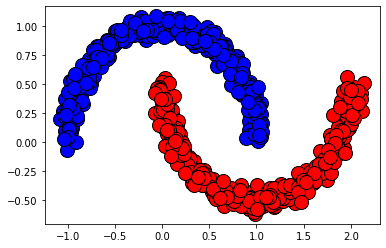

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=750, noise=0.05)
dbscan = DBSCAN(eps=0.2, min_samples = 5)
dbscan.fit(X)

labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Create a boolean array where the True values indicate points that aren't noise
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True


unique_labels = set(labels)
colors = ['red','blue']

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'black'

    class_member_mask = (labels == k)
    print(class_member_mask.shape)
    print(labels.shape)
    print(X.shape)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', c=col,
             markeredgecolor='k', markersize=14)

    # noise
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', c=col,
             markeredgecolor='k', markersize=6)




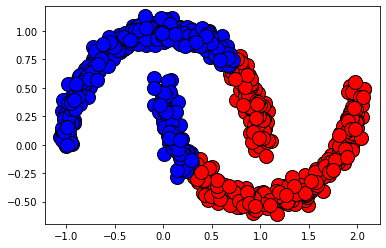

In [82]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=750, noise=0.05, random_state=0)
kmeans = KMeans(n_clusters = 2)
labels = kmeans.fit_predict(X)

unique_labels = set(labels)
cluster = []

colors = ['red','blue']
for n_cluster in unique_labels:
    cluster= X[labels == n_cluster]
    plt.plot(cluster[:,0],cluster[:,1],'o',c=colors[n_cluster],
             markeredgecolor='k', markersize=14)


K-means is limited to linear cluster boundaries. A solution to this is to use the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data and then assigns labels using a k-means algorithm.

This algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it(i.e., it reduces its dimensionality), and then it uses another clustering algorithm in this low-dimensional space(Scikit-Learn's implementation uses k-means)

- can capture complex cluster structure and it can also be used to cut graphs (i.e. to identify clusters of friends on a social network), however it does not scale well to large number of instances, and it does not behave well when the clusters have very different sizes

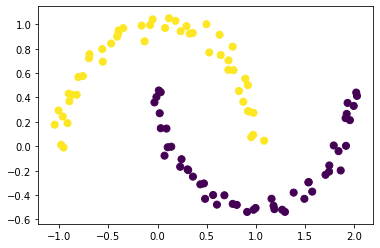

In [98]:
from sklearn.cluster import SpectralClustering 
X, y = make_moons(100, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


**Gaussian Mixtures**
A Gaussian mixture model is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances were generated from a mixture of several Gaussian distributions whose paramters are unknown. 
All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation.



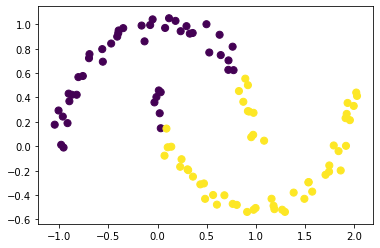

In [101]:
from sklearn import mixture
X, y = make_moons(100, noise=.05, random_state=0)
gmm = mixture.GaussianMixture(n_components =2)
gmm.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


In [39]:
import matplotlib.pyplot as plt
from sklearn import datasets, mixture
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import adjusted_rand_score

# import sys
# !{sys.executable} -m pip install rerf
import rerf

from rerf.urerf import UnsupervisedRandomForest

# Load dataset
iris = datasets.load_iris()

X = iris.data

clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)

clf.fit(X)
sim_mat = clf.transform()

agg_cluster = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
kmeans_cluster = KMeans(n_clusters = 3)
gmm_cluster = mixture.GaussianMixture(n_components =3)

agg_predict_labels = agg_cluster.fit_predict(sim_mat)
kmeans_predict_labels = kmeans_cluster.fit_predict(sim_mat)
gmm_predict_labels = gmm_cluster.fit_predict(sim_mat)

agg_score = adjusted_rand_score(iris.target, agg_predict_labels)
kmeans_score = adjusted_rand_score(iris.target, kmeans_predict_labels)
gmm_score = adjusted_rand_score(iris.target,gmm_predict_labels)

print("Adjusted Rand Score:", agg_score, kmeans_score,
      gmm_score)

Adjusted Rand Score: 0.7195837484778037 0.7073626391173136 0.7861639322874198
